# Exploratory Data Analysis (EDA)

## 1. Load and filter

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
raw_path = '../data/raw/complaints.csv'
print("⏳ Loading dataset... (this may take a moment)")

# Define the exact names of the columns in the CSV
cols_to_keep = ['Consumer complaint narrative', 'Product']

df = pd.read_csv(
    raw_path, 
    usecols=cols_to_keep, # Loads only specific columns to save RAM.
    dtype=str  # Forces pandas to treat everything as text. 
) # This prevents the DtypeWarning and speeds up loading.

print(f"Original shape (rows, cols): {df.shape}")

# Filter nulls immediately (Optimization)
# We drop rows with missing text BEFORE renaming to ensure we work with clean data.
df = df.dropna(subset=['Consumer complaint narrative'])

# Rename columns safely
# Using a dictionary is safer than a list because it maps explicitly by name.
df = df.rename(columns={
    'Consumer complaint narrative': 'text',
    'Product': 'category'
})

print("✅ Data loaded and cleaned successfully.")
print(f"Final shape: {df.shape}")

# Quick look at the data structure
display(df.head())

⏳ Loading dataset... (this may take a moment)
Original shape (rows, cols): (1282355, 2)
✅ Data loaded and cleaned successfully.
Final shape: (383564, 2)


,category,text
29904,"Credit reporting, credit repair services, or o...",The Summer of XX/XX/2018 I was denied a mortga...
30629,"Credit reporting, credit repair services, or o...",There are many mistakes appear in my report wi...
30735,"Credit reporting, credit repair services, or o...",There are many mistakes appear in my report wi...
30795,"Credit reporting, credit repair services, or o...",There are many mistakes appear in my report wi...
30807,"Credit reporting, credit repair services, or o...",There are many mistakes appear in my report wi...


## 2. Target variable analysis (Distribution)

Total unique categories: 18

Top 10 Categories by volume:
--------------------------------------------------
category
Credit reporting, credit repair services, or other personal consumer reports    92378
Debt collection                                                                 86710
Mortgage                                                                        52987
Credit reporting                                                                31588
Student loan                                                                    21810
Credit card or prepaid card                                                     21379
Credit card                                                                     18838
Bank account or service                                                         14885
Checking or savings account                                                     12881
Consumer Loan                                                                    9474
Name: count, dtype: in

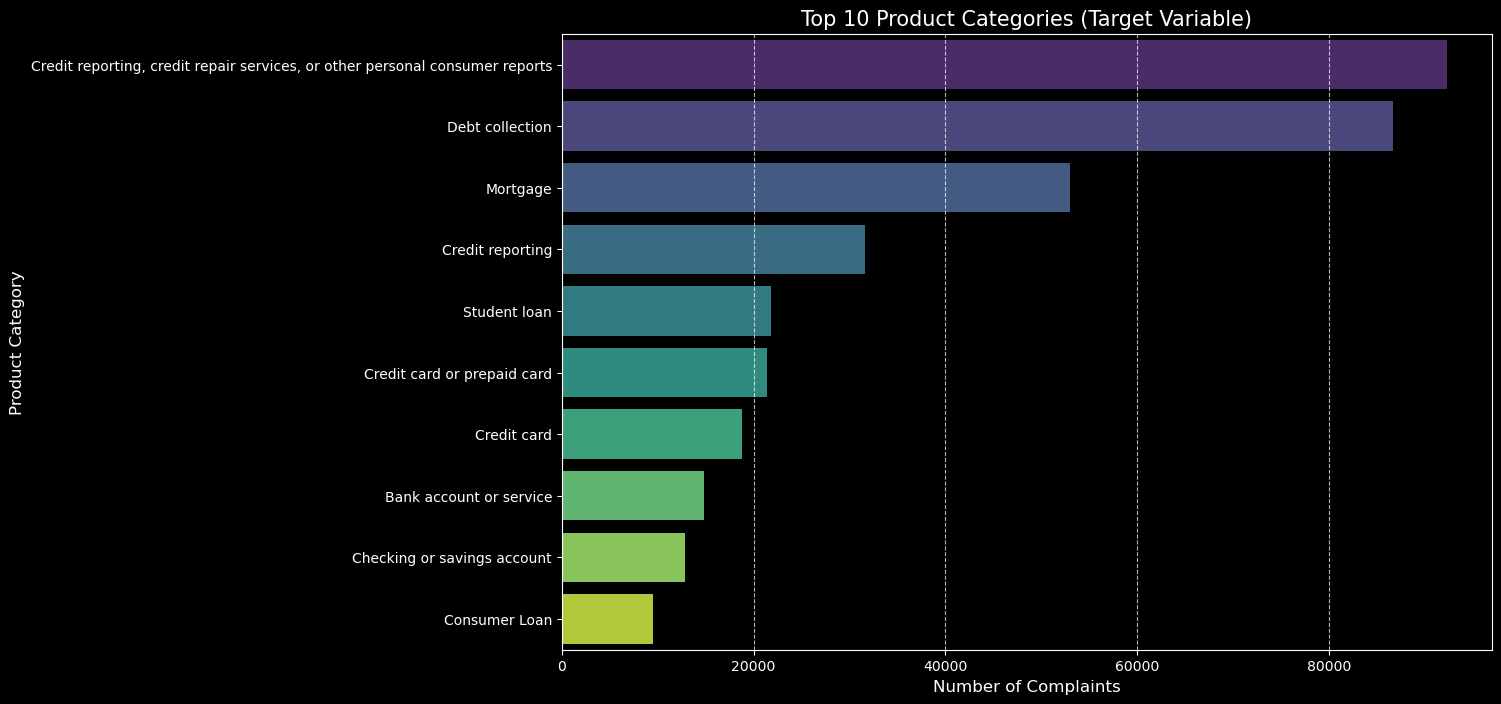


📊 Insight: The Top 5 categories cover 74.43% of the dataset.


In [ ]:
# ---------------------------------------------------------
# Target variable analysis (Class balance)
# ---------------------------------------------------------

# A. Calculate the distribution of categories
category_counts = df['category'].value_counts()
total_complaints = len(df)

print(f"Total unique categories: {len(category_counts)}")
print("\nTop 10 Categories by volume:")
print("-" * 50)
print(category_counts.head(10))

# B. Visualize the Top 10 categories
# We use a horizontal bar chart because category names are long.
plt.figure(figsize=(12, 8))
sns.barplot(
    x=category_counts.head(10).values, 
    y=category_counts.head(10).index, 
    palette='viridis',
    hue=category_counts.head(10).index, # Avoids future warning
    legend=False
)

plt.title('Top 10 Product Categories (Target Variable)', fontsize=15)
plt.xlabel('Number of Complaints', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# C. Cumulative coverage analysis
# This tells us how much of the dataset is covered by the top classes.
top_5_coverage = category_counts.head(5).sum() / total_complaints * 100
print(f"\n📊 Insight: The Top 5 categories cover {top_5_coverage:.2f}% of the dataset.")

The government agency (CFPB) changed category names over the years, creating duplicate topics:

- Credit Reporting: We have "Credit reporting" (old) AND "Credit reporting, credit repair..." (new).

- Credit Cards: We have "Credit card" AND "Credit card or prepaid card".

- Banking: We have "Bank account or service" AND "Checking or savings account".

If we train the model now, it will get confused between "Credit card" and "Credit card or prepaid card". We must consolidate these into 5 Main Super-Categories to build a robust model.

## 3. Category consolidation

Shape before consolidation: (383564, 2)
Shape after consolidation and filtering: (333096, 3)

Final Class Distribution (The Big 5):
target
Credit Reporting    123966
Debt Collection      86710
Mortgages            52987
Credit Card          41667
Retail Banking       27766
Name: count, dtype: int64


C:\Users\javie\AppData\Local\Temp\ipykernel_7392\232246601.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='target', data=df_clean, order=df_clean['target'].value_counts().index, palette='viridis')


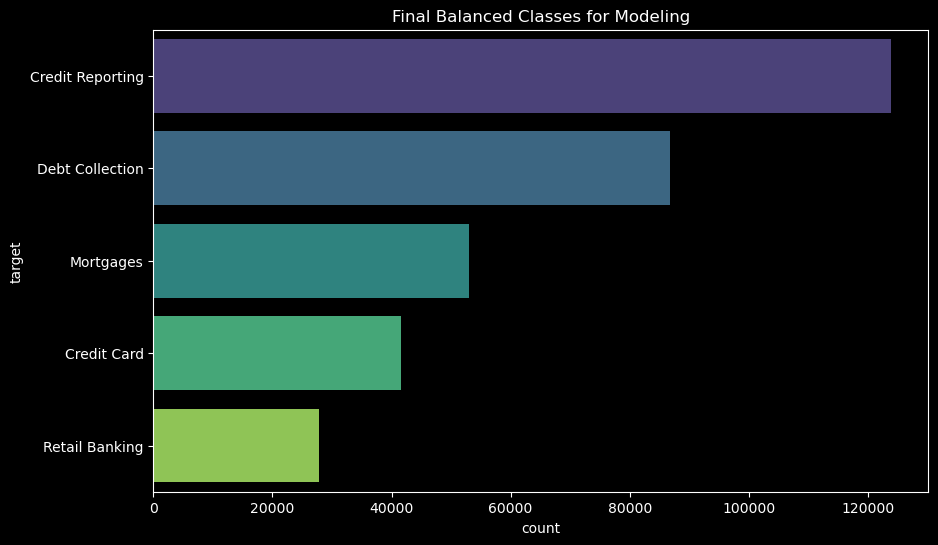

In [ ]:
# ---------------------------------------------------------
# Data cleaning: Category consolidation
# ---------------------------------------------------------

# We noticed that many categories are actually the same topic with different names.
# We will merge them into 5 distinct "Super Classes" for better model performance.

def consolidate_categories(df):
    # Dictionary mapping old/complex names to clean groups
    category_mapping = {
        # Group 1: Credit reporting
        'Credit reporting, credit repair services, or other personal consumer reports': 'Credit Reporting',
        'Credit reporting': 'Credit Reporting',
        
        # Group 2: Debt collection
        'Debt collection': 'Debt Collection',
        
        # Group 3: Mortgages
        'Mortgage': 'Mortgages',
        
        # Group 4: Credit cards (Merge prepaid and standard)
        'Credit card or prepaid card': 'Credit Card',
        'Credit card': 'Credit Card',
        'Prepaid card': 'Credit Card',
        
        # Group 5: Retail banking (Merge checkings, savings, bank accounts)
        'Bank account or service': 'Retail Banking',
        'Checking or savings account': 'Retail Banking'
    }
    
    # Apply the mapping
    # We create a new column 'target' with the clean names
    df['target'] = df['category'].map(category_mapping)
    
    # Important: Drop rows that didn't match our Top 5 mapping (e.g., "Student Loan", "Money Transfer")
    # For this project, we want to focus on the "Big 5" banking products.
    df_clean = df.dropna(subset=['target'])
    
    return df_clean

# Apply the consolidation
print(f"Shape before consolidation: {df.shape}")
df_clean = consolidate_categories(df)
print(f"Shape after consolidation and filtering: {df_clean.shape}")

# Check the new clean distribution
print("\nFinal Class Distribution (The Big 5):")
print(df_clean['target'].value_counts())

# Visualize the final dataset
plt.figure(figsize=(10, 6))
sns.countplot(y='target', data=df_clean, order=df_clean['target'].value_counts().index, palette='viridis')
plt.title('Final Balanced Classes for Modeling')
plt.show()

**💡 Why drop "Student Loans" or "Consumer Loans"?**

Is better to have 5 very distinct classes with lots of data (High accuracy) than 18 classes where some are very small or confusing.

By focusing on Credit Reporting, Debt Collection, Mortgages, Credit Cards, and Retail Banking, we cover the vast majority of the banking sector.

## 4. Save the data

In [ ]:
# ---------------------------------------------------------
# Save the consolidated dataset
# ---------------------------------------------------------

# We save this version because it has the clean target labels ('target')
# but the text is still raw (we haven't run spaCy yet).

save_path = '../data/raw/complaints_5_classes_raw.csv'

# We only keep the two columns we need
df_clean = df_clean[['text', 'target']]

df_clean.to_csv(save_path, index=False)

print(f"✅ Saved consolidated dataset to: {save_path}")
print("🚀 Ready for Preprocessing.")

✅ Saved consolidated dataset to: ../data/raw/complaints_5_classes_raw.csv
🚀 Ready for Preprocessing.
